In [1]:
from dataclasses import dataclass
import tqdm
from typing import Callable, Dict, Optional, Tuple, Union

import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor
from torch.distributions import Distribution as torchDist

from distributions import SamplableDistribution, GaussianMixture, Distribution
from samplers import samplers, base_sampler
from samplers.stopping_rule import TVStop
from tools.benchmark import BenchmarkUtils, Benchmark

/tmp/ipykernel_14324/1611961378.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

base_meta = {
    "sigma": 1.,
    "sigma_lr": 0.015,
    "target_acceptance": 0.574,
    "device": device,
}

meta_fisher={
    "damping": 10,
}

In [26]:
chain_count = 5
dimensions = [2, 5, 10, 20]
gaussian_count = 5
tv_threshold = 0.05
distance_to_mass_points = 1.
sample_count = 1000
sample_iter_limit = 2000
burn_in_iter_count = 5000
probe_period = 100
cube = 1.
tail_count_cap = 1000

stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
                       projection_count=25, tail_count_cap=tail_count_cap)
                       
algs = {
    "fisher_mala": samplers.FisherMALAVanilla(
        pipeline=None,
        sigma_burn_in_params=base_meta.copy(),
        sigma_burn_in_iter_count=500,
        prec_burn_in_params=meta_fisher.copy(),
        prec_burn_in_iter_count=burn_in_iter_count - 500,
        sample_iter_count=sample_iter_limit,
        stopping_rule=stopping_rule,
        probe_period=probe_period
    ),
    "mala": samplers.MALAVanilla(
        pipeline=None,
        sigma_burn_in_params=base_meta.copy(),
        sigma_burn_in_iter_count=burn_in_iter_count,
        sample_iter_count=sample_iter_limit,
        stopping_rule=stopping_rule,
        probe_period=probe_period
    ),
}

hist_data = {}

for dimension in tqdm.tqdm(dimensions):
    print("Processing dimension", dimension)
    hist_data[dimension] = {}

    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    true_covs = torch.rand((gaussian_count, dimension, dimension))
    true_covs = (
        true_covs @ true_covs.permute(0, 2, 1) + 
        torch.eye(dimension).repeat(gaussian_count, 1, 1)
    )

    gm = GaussianMixture(true_means, true_covs,
                         torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64))

    starting_points = BenchmarkUtils.generate_starting_points(
        chain_count, dimension,
        true_means,
        distance_to_mass_points
    )
    true_samples = gm.sample(sample_count)

    params = base_sampler.Params(
        target_dist=gm,
        starting_point=starting_points,
        proposal_dist=torch.distributions.MultivariateNormal(
            torch.zeros(dimension, device=device),
            torch.eye(dimension, device=device),
        ),
    )
    base_meta_adj = base_meta.copy()
    base_meta_adj["sigma"] /= dimension

    for alg in algs:
        print("-" * 80)
        params.meta = base_meta_adj.copy()

        algs[alg].load_params(params)
        algs[alg].load_true_samples(true_samples)
        algs[alg].run()

    
        hist_data[dimension][alg] = [algs[alg].pipeline.sample_blocks[-1].iteration.cache,
                                     algs[alg].pipeline.sample_blocks[-1].stop_data_hist]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing dimension 2
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1
processing block: 2
processing block: 3
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1
processing block: 2


 25%|██▌       | 1/4 [01:01<03:03, 61.28s/it]

Processing dimension 5
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1
processing block: 2
processing block: 3
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1
processing block: 2


 50%|█████     | 2/4 [02:39<02:45, 82.80s/it]

Processing dimension 10
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1
processing block: 2
processing block: 3
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1
processing block: 2


 75%|███████▌  | 3/4 [04:41<01:40, 100.84s/it]

Processing dimension 20
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1
processing block: 2
processing block: 3
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1
processing block: 2


100%|██████████| 4/4 [06:46<00:00, 101.62s/it]


In [20]:
tv_threshold = 0.05

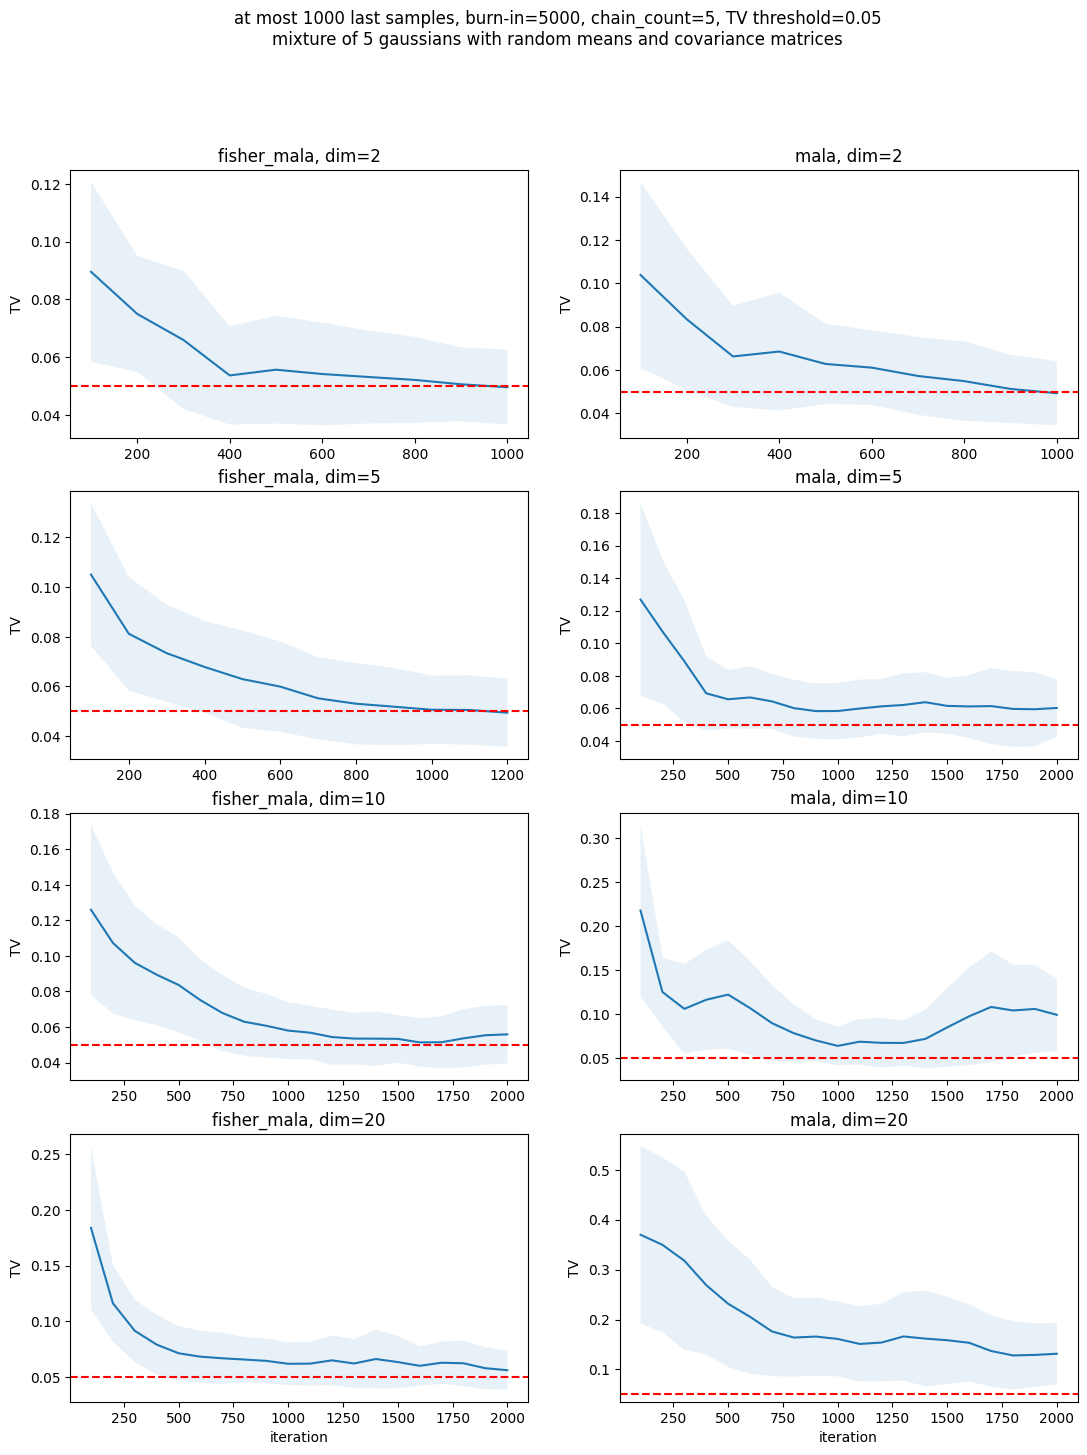

In [28]:
fig, axes = plt.subplots(nrows=len(dimensions), ncols=2, figsize=(13, 4*len(dimensions), ))
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ]
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")

In [4]:
algs["mala"].pipeline.sample_blocks[0].iteration.cache.params.meta

{'sigma': tensor([[1.4361],
         [1.3949]]),
 'sigma_lr': 0.015,
 'target_acceptance': 0.574,
 'device': 'cpu'}

In [5]:
algs["mala"].pipeline.sample_blocks[1].iteration.cache.params.meta

{'sigma': tensor([[1.4534],
         [1.3571]]),
 'sigma_lr': 0.015,
 'target_acceptance': 0.574,
 'device': 'cpu'}

In [6]:
algs["fisher_mala"].pipeline.sample_blocks[0].iteration.cache.params.meta

{'sigma': tensor([[1.4518],
         [1.4794]]),
 'sigma_lr': 0.015,
 'target_acceptance': 0.574,
 'device': 'cpu'}

In [7]:
algs["fisher_mala"].pipeline.sample_blocks[1].iteration.cache.params.meta

{'sigma': tensor([[1.8536],
         [1.9620]]),
 'sigma_lr': 0.015,
 'target_acceptance': 0.574,
 'device': 'cpu',
 'damping': 10,
 'prec': tensor([[[0.0840, 0.0201, 0.0154, 0.0169, 0.0237, 0.0175, 0.0150, 0.0135,
           0.0165, 0.0169],
          [0.0182, 0.0900, 0.0146, 0.0150, 0.0199, 0.0161, 0.0210, 0.0203,
           0.0213, 0.0208],
          [0.0122, 0.0148, 0.0784, 0.0141, 0.0133, 0.0152, 0.0125, 0.0169,
           0.0100, 0.0108],
          [0.0165, 0.0154, 0.0144, 0.0801, 0.0167, 0.0194, 0.0167, 0.0122,
           0.0109, 0.0113],
          [0.0217, 0.0184, 0.0140, 0.0156, 0.0804, 0.0149, 0.0151, 0.0158,
           0.0148, 0.0176],
          [0.0170, 0.0189, 0.0152, 0.0181, 0.0160, 0.0829, 0.0199, 0.0163,
           0.0158, 0.0166],
          [0.0115, 0.0207, 0.0119, 0.0151, 0.0178, 0.0169, 0.0763, 0.0173,
           0.0200, 0.0174],
          [0.0126, 0.0177, 0.0133, 0.0105, 0.0142, 0.0161, 0.0158, 0.0859,
           0.0129, 0.0140],
          [0.0136, 0.0190, 0.0082, 0

In [8]:
algs["fisher_mala"].pipeline.sample_blocks[2].iteration.cache.params.meta

{'sigma': tensor([[0.3930],
         [0.4025]]),
 'sigma_lr': 0.015,
 'target_acceptance': 0.574,
 'device': 'cpu',
 'damping': 10,
 'prec': tensor([[[0.0574, 0.0038, 0.0019, 0.0050, 0.0091, 0.0072, 0.0016, 0.0032,
           0.0049, 0.0075],
          [0.0041, 0.0573, 0.0035, 0.0049, 0.0039, 0.0041, 0.0067, 0.0055,
           0.0044, 0.0044],
          [0.0018, 0.0037, 0.0541, 0.0031, 0.0034, 0.0050, 0.0048, 0.0048,
           0.0023, 0.0024],
          [0.0045, 0.0050, 0.0033, 0.0580, 0.0084, 0.0064, 0.0047, 0.0032,
           0.0013, 0.0026],
          [0.0090, 0.0035, 0.0031, 0.0084, 0.0570, 0.0051, 0.0042, 0.0040,
           0.0050, 0.0072],
          [0.0072, 0.0040, 0.0050, 0.0062, 0.0055, 0.0540, 0.0057, 0.0056,
           0.0042, 0.0021],
          [0.0013, 0.0063, 0.0050, 0.0049, 0.0043, 0.0055, 0.0529, 0.0049,
           0.0053, 0.0034],
          [0.0027, 0.0049, 0.0045, 0.0030, 0.0040, 0.0058, 0.0047, 0.0594,
           0.0064, 0.0016],
          [0.0055, 0.0043, 0.0023, 0

In [ ]:
alg_fisher_mala_vanilla = base_sampler.Pipeline(
    [
        base_sampler.SampleBlock(
            iteration=samplers.MALAIter(base_sampler.Cache(params)),
            iteration_count=500,
        ),
        base_sampler.SampleBlock(
            iteration=samplers.FisherMALAIter(base_sampler.Cache(params.update_meta(meta_fisher))),
            iteration_count=500,
        ),
        base_sampler.SampleBlock(
            iteration=samplers.FisherMALAIter(base_sampler.Cache(params.update_meta(meta_fisher), true_samples=true_samples)),
            iteration_count=1000,
            stopping_rule=TVStop(threshold=0.05, density_probe_count=1000, projection_count=25,
                                 tail_count_cap=1000),
            probe_period=50,
        ),
    ]
)

In [ ]:
alg_mala_vanilla = base_sampler.Pipeline(
    [
        base_sampler.SampleBlock(
            iteration=samplers.MALAIter(base_sampler.Cache(params=params)),
            iteration_count=1000,
        ),
        base_sampler.SampleBlock(
            iteration=samplers.MALAIter(base_sampler.Cache(params, true_samples=true_samples)),
            iteration_count=10000,
            stopping_rule=TVStop(threshold=0.05, density_probe_count=1000, projection_count=25,
                                 tail_count_cap=1000),
            probe_period=50,
        )
    ]
)

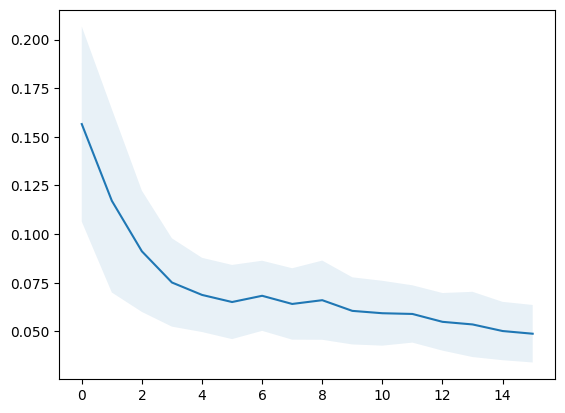

In [ ]:
plt.plot([entry["tv_mean"] for entry in alg_fisher_mala_vanilla.sample_blocks[-1].stop_data_hist])
plt.fill_between(dddd
    range(len(alg_fisher_mala_vanilla.sample_blocks[-1].stop_data_hist)),
    [
        entry["tv_mean"] - entry["tv_std"]
        for entry in alg_fisher_mala_vanilla.sample_blocks[-1].stop_data_hist
    ],
    [
        entry["tv_mean"] + entry["tv_std"]
        for entry in alg_fisher_mala_vanilla.sample_blocks[-1].stop_data_hist
    ],
    alpha=0.1
)

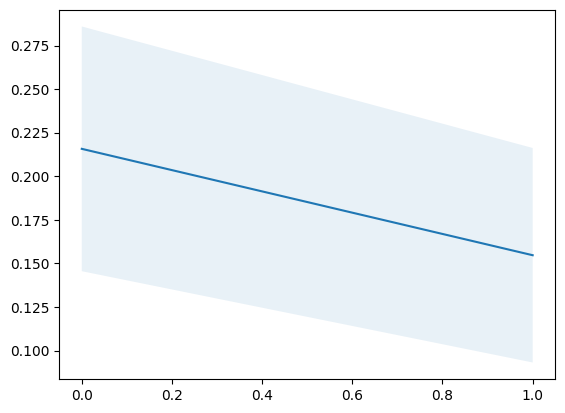

In [ ]:
plt.plot([entry["tv_mean"] for entry in alg_mala_vanilla.sample_blocks[-1].stop_data_hist])
plt.fill_between(
    range(len(alg_mala_vanilla.sample_blocks[-1].stop_data_hist)),
    [
        entry["tv_mean"] - entry["tv_std"]
        for entry in alg_mala_vanilla.sample_blocks[-1].stop_data_hist
    ],
    [
        entry["tv_mean"] + entry["tv_std"]
        for entry in alg_mala_vanilla.sample_blocks[-1].stop_data_hist
    ],
    alpha=0.1
)

In [ ]:
from tools.metrics import tv_threshold

In [ ]:
tv_threshold(jnp.array(alg_fisher_mala_vanilla.sample_blocks[-1].iteration.cache.true_samples),
             jnp.array(alg_fisher_mala_vanilla.sample_blocks[-1].iteration.cache.samples), density_probe_count=1000, projection_count=25)

(Array(0.04875464, dtype=float32), Array(0.01478958, dtype=float32))

In [ ]:
res = alg_fisher_mala_vanilla.sample_blocks[-1].iteration.cache.samples

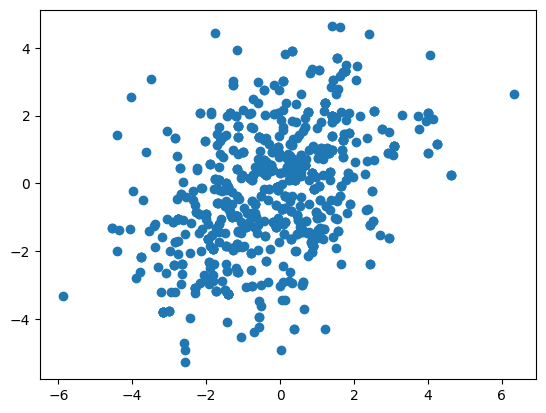

In [ ]:
plt.scatter(res[:, 0, 0], res[:, 0, 1])

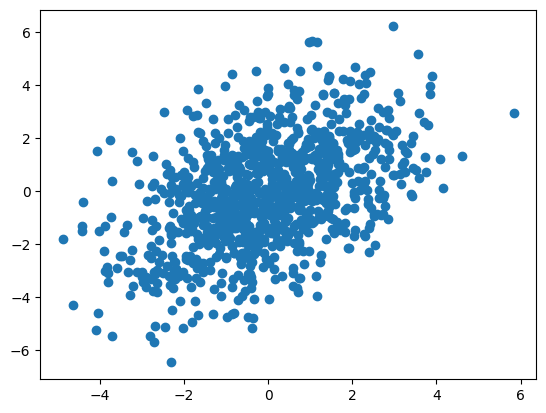

In [ ]:
true_samples = gm.sample(sample_count)
plt.scatter(true_samples[:, 0], true_samples[:, 1])